In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.locationsolvers.imaging import *

from pyfrac.locationsolvers.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

In [39]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

# LOAD DATA, Rec, Models

In [40]:
# Load velocity model
abs_bounds = 30 # boundary points
dx = dy = dz = 0.005  # 5mm
dimlims = 0.4 
nx = ny = nz = int(dimlims/dx)
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3

In [41]:
# RECEIVERS
recgeom = np.loadtxt('/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/homoRB_DAS/inputs/receiver.dat').T
recgeom = recgeom - (abs_bounds*dx)
nr = recs.shape[1]
print(nr)


36504


In [46]:
seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/homoRB_DAS/outputs/su'
vy = read_seis(os.path.join(seispath,'homoRB_DAS_p.txt'), nr)
print(vy.shape)

(36504, 10000)


In [43]:
fs_kHz = 100
fs = fs_kHz * 1000
rec_dt = 1/fs

rec_t = np.arange(0,vy.shape[1]*rec_dt, rec_dt)
nt = len(rec_t)

rec_t.shape

(10000,)

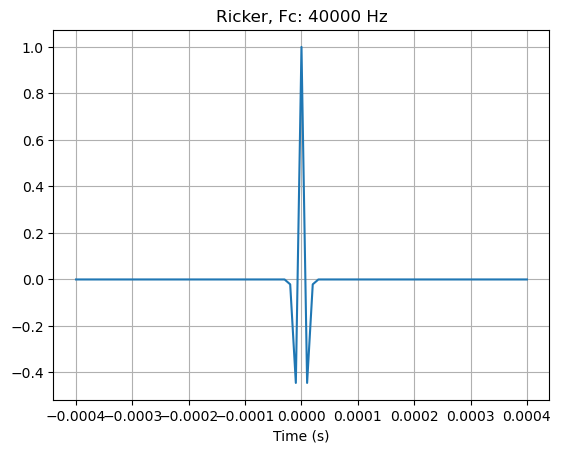

In [44]:
# Make wavelet
fwav = 40000  # WAVELET CENTRAL FREQUENCY
nt = 251  # TIME SAMPLES

wav, wavt, wavc = ricker(rec_t[:41], f0=fwav)
plt.plot(wavt, wav,)
plt.xlabel('Time (s)')
plt.title('Ricker, Fc: %i Hz'%fwav)
plt.grid()

# MAKE DATA

In [47]:
vy.shape

(36504, 10000)

In [48]:
tshift = 450 # index of source ignition
vy = vy[:,tshift:tshift+100]
nt = vy.shape[1]
nt

100

In [49]:
recgeom.shape

(3, 36504)

In [50]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=rec_t[:nt], 
               srcs=recgeom[:, :1], 
               recs=recgeom, 
               vel=vp, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

MemoryError: Unable to allocate 139. GiB for an array with shape (512000, 36504) and data type float64

In [32]:
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)

traceimage(frwddata[:50,:40], climQ=99.99)

ValueError: cannot reshape array of size 1650 into shape (36504,550)

In [ ]:
traceimage(vy[:50,:40], climQ=99.99)

In [ ]:
fig,axs = plt.subplots(1,2, figsize=[12,6])
traceimage(frwddata[:50,:60], climQ=99.99, ax=axs[0])
traceimage(vy[:50,:60], climQ=99.99, ax=axs[1])
axs[0].set_title('Frwd Model')
axs[1].set_title('eFD')

In [12]:
migrated_synth, hc_synth = migration(Op, frwddata, (nx,ny,nz), nforhc=10)
migrated, hc = migration(Op, vy, (nx,ny,nz), nforhc=10)

print('Synth. Migration Hypo Center:',hc_synth)
print('eFD Migration Hypo Center:',hc)

Synth. Migration Hypo Center: [20.2 20.2 20.2]
eFD Migration Hypo Center: [20.7 20.6 20.7]


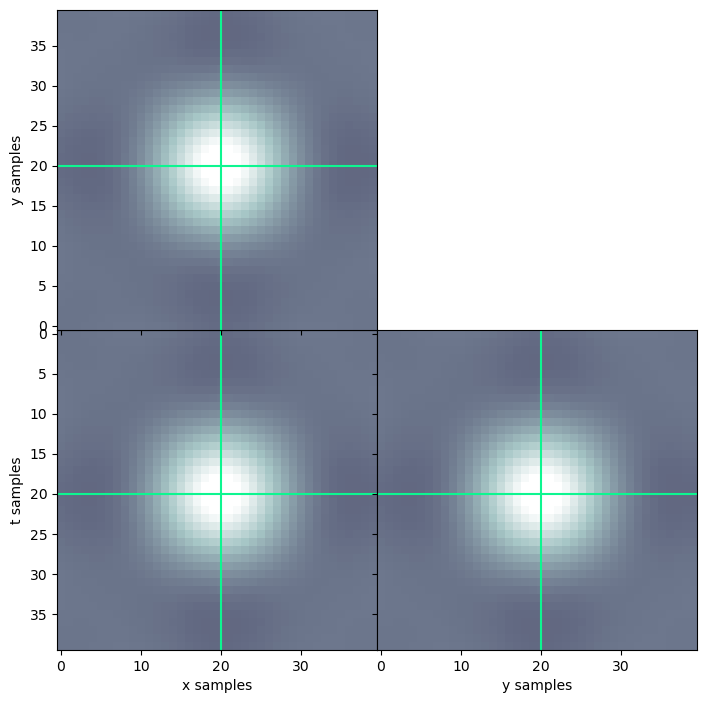

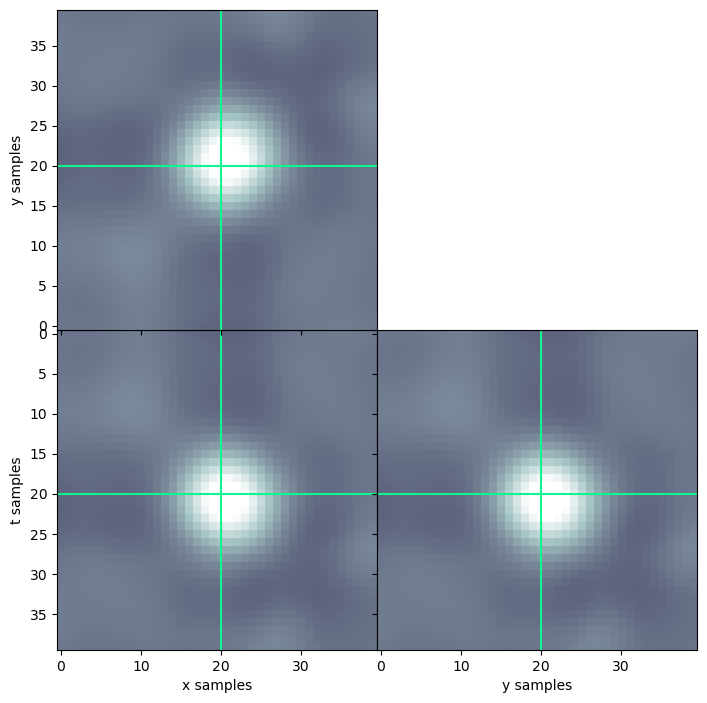

In [13]:
fig,axs = locimage3d(migrated_synth,20,20)
fig,axs = locimage3d(migrated,20,20)


# Inversion

In [14]:
inv_synth, hc_synth = lsqr_migration(Op, frwddata, [nx,ny,nz], niter=100, nforhc=10, verbose=True)
inv, hc = lsqr_migration(Op, vy, [nx,ny,nz], niter=100, nforhc=10, verbose=True)

print('Synth. LSQR Hypo Center:',hc_synth)
print('eFD LSQR Hypo Center:',hc)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 4271352 rows and 64000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.413e+01  8.413e+01    1.0e+00  2.8e+01
     1 -6.67881e-06   4.518e+01  4.518e+01    5.4e-01  5.2e-01   2.8e+03  1.0e+00
     2  3.41112e-06   3.115e+01  3.115e+01    3.7e-01  2.9e-01   3.6e+03  2.3e+00
     3  3.70175e-05   2.573e+01  2.573e+01    3.1e-01  1.8e-01   4.2e+03  3.7e+00
     4  4.04087e-05   2.380e+01  2.380e+01    2.8e-01  1.6e-01   4.7e+03  5.1e+00
     5  7.49259e-05   1.957e+01  1.957e+01    2.3e-01  1.7e-01   5.2e+03  8.2e+00
     6  8.17088e-05   1.789e+01  1.789e+01    2.1e-01  1.1e-01   5.8e+03  1.0e+01
     7  8.04825e-05   1.615e+01  1.615e+01    1.9e-01  7.9e-02   6.2e+03  1.3e+01
     8  6.77104e-05   1.519e+0

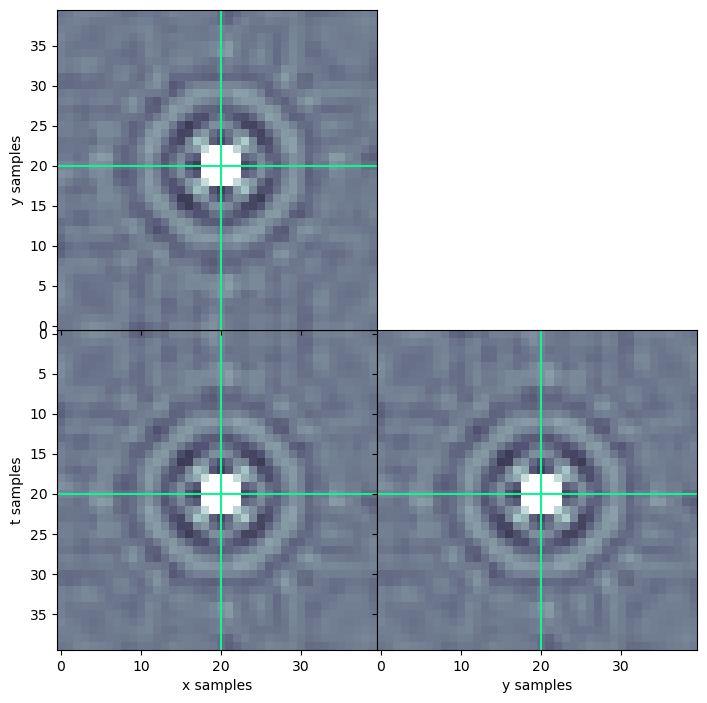

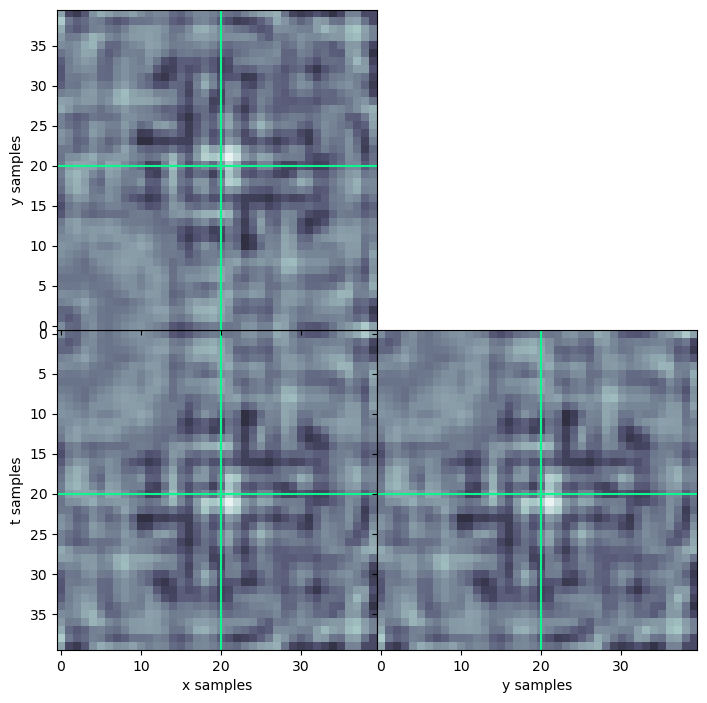

In [15]:
fig,axs = locimage3d(inv_synth,20,20)
fig,axs = locimage3d(inv,20,20)

# X-Corr Imaging

In [17]:
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

In [ ]:
xc_synth, hc_synth, _, _ = xcorr_imaging(Op, frwddata, [nx,ny,nz], niter=100, xceps=8e-1, lr=1e-5, nforhc=10, verbose=True)
xc, hc, _, _ = xcorr_imaging(Op, vy, [nx,ny,nz], niter=100, xceps=8e-1, lr=1e-5, nforhc=10, verbose=True)

print('Synth. X-Corr Hypo Center:',hc_synth)
print('eFD X-Corr Hypo Center:',hc)

Iteration 0, Loss: 3.31699
Iteration 10, Loss: 1.20994
Iteration 20, Loss: 0.65940


In [ ]:
fig,axs = locimage3d(xc_synth,20,20)
fig,axs = locimage3d(xc,20,20)